
# Project Outline

1. **Data Loading and Preprocessing**

   1. Load the dataset.
   2. Exploratory Data Analysis:
      - Feature histograms.
      - Train-Test Split (to avoid leakage).
      - Check for outliers (and optional removal).
      - Scaling (Standardization).
      - Correlation Matrix and Multicollinearity Check:
        - Remove highly correlated features.
   3. Prepare final features for analysis.

2. **Linear Algorithms**

   1. Perceptron
      - Train with 5-fold cross-validation (CV).
      - Hyperparameter tuning using CV.
      - Evaluate the best-tuned model on the test set.
   2. Pegasos SVM
      - Train with 5-fold cross-validation.
      - Evaluate the model on the test set.
   3. Logistic Regression
      - Train with 5-fold cross-validation.
      - Evaluate the model on the test set.
   4. Comparison of Results
      - Summarize and compare accuracies across Perceptron, Pegasos SVM, and Logistic Regression.

3. **Polynomial Feature Expansion**

   1. Expand features to degree 2 (include squared terms and interactions).
   2. Retrain and evaluate:
      - Perceptron with polynomial expansion.
      - Pegasos SVM with polynomial expansion.
      - Logistic Regression with polynomial expansion.
   3. Summarize and compare results:
      - Linear vs. Polynomial-expanded features.
      - Visualize results.

4. **Kernelized Methods**

   1. Kernelized Perceptron
      - Implement and evaluate with:
        - Gaussian Kernel.
        - Polynomial Kernel.
      - Compare test set accuracies.
   2. Kernelized Pegasos SVM
      - Implement and evaluate with:
        - Gaussian Kernel.
        - Polynomial Kernel.
      - Compare test set accuracies.

5. **Final Comparison**

   1. Summarize final results:
      - Linear models.
      - Polynomial-expanded models.
      - Kernelized models.



# Kernelized Linear Classification

## Initial imports + functions

Basic libraries + custom functions (ffunctions.py):

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Uncomment the following line if you want that plots appear inline in a real Jupyter notebook:
# %matplotlib inline

from ffunctions import (
    load_data,
    train_test_split,
    detect_outliers_zscore,
    remove_outliers,
    standard_scaler_fit,
    standard_scaler_transform,
    check_high_correlation,
    k_fold_cross_validation,
    perceptron_classifier_func,
    pegasos_classifier_func,
    logistic_regression_classifier_func,
    perceptron_classifier_func_eta,
    perceptron_train,
    perceptron_predict,
    pegasos_train,
    pegasos_predict,
    logistic_regression_train,
    logistic_regression_predict,
    polynomial_feature_expansion,
    gaussian_kernel,
    polynomial_kernel,
    kernelized_perceptron_classifier_func,
    kernelized_perceptron_train,
    kernelized_perceptron_predict,
    kernelized_pegasos_classifier_func,
    kernelized_pegasos_train,
    kernelized_pegasos_predict
)

Data loading:

In [2]:
csv_path = "YOUR_PATH_HERE"
df = load_data(csv_path)
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,1.205492,5.823226,98.837539,-1.075852,0.999205,0.911543,3.623558,-1.720267,-0.346191,-54.708330,-1
1,1.692571,-0.887019,100.901276,-0.595548,0.177550,-0.915495,4.320264,0.907834,3.126815,-56.397484,-1
2,4.289320,1.416843,100.784735,-2.897154,-0.066972,-0.786173,2.093003,1.336237,2.183829,-56.197728,1
3,0.542420,-1.010095,100.015580,-3.070705,0.088324,-0.242669,0.767942,-0.284683,-2.104145,-55.794045,1
4,2.431765,-1.224177,100.709237,-0.102892,0.699031,-0.656315,-0.911784,-1.355873,1.537825,-55.917863,-1


# Exploratory Data Analysis

Understanding feature locations and shape

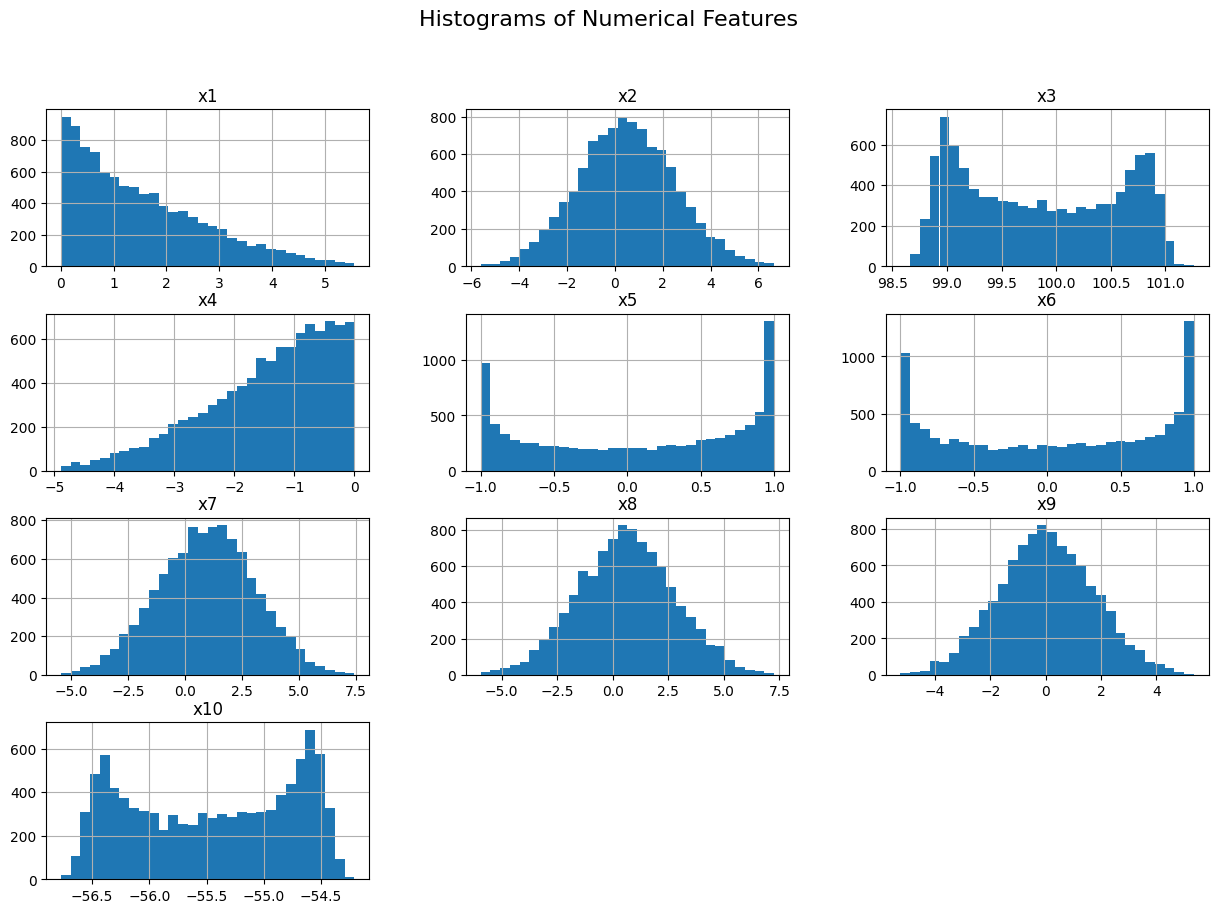

In [3]:
feature_cols = [f"x{i}" for i in range(1, 11)]
df[feature_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()

Train - Test split as first data leakage countermeasure:

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)


Train set shape: (7788, 11)
Test set shape: (1947, 11)


Checking for outliers in training set

In [5]:
outlier_indices = detect_outliers_zscore(train_df, feature_cols, z_thresh=3.0)
print(f"Number of outliers detected in training set: {len(outlier_indices)}")


Number of outliers detected in training set: 78


Outliers removal:


In [6]:
train_df_no_outliers = remove_outliers(train_df, outlier_indices)
print("Train set (no outliers) shape:", train_df_no_outliers.shape)

Train set (no outliers) shape: (7710, 11)


Applying consistent scaling


In [7]:
means, stds = standard_scaler_fit(train_df_no_outliers, feature_cols)
train_scaled = standard_scaler_transform(train_df_no_outliers, feature_cols, means, stds)
test_scaled = standard_scaler_transform(test_df, feature_cols, means, stds)


Correlation Matrix

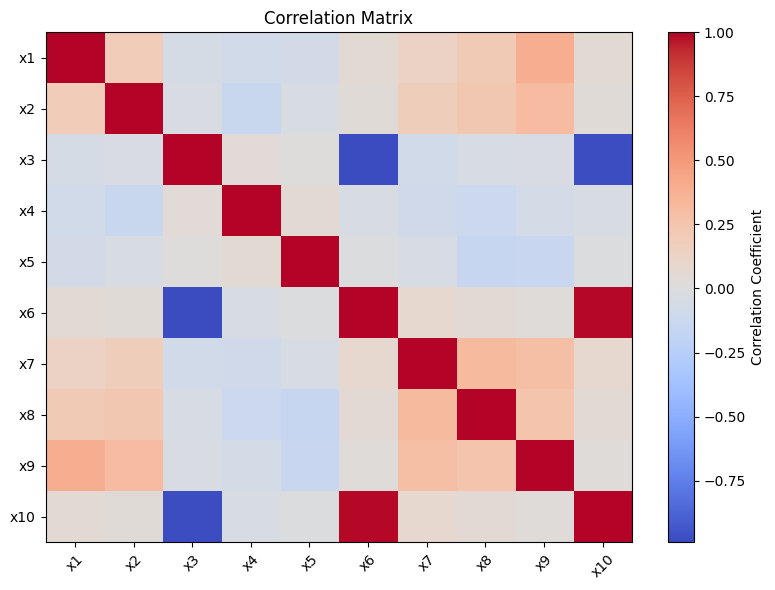

In [8]:
# 5. Correlation Matrix (for numerical columns)
corr_matrix = train_scaled[feature_cols].corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.tight_layout()
plt.show()


Multicollinearity Check

In [9]:
high_corr_pairs = check_high_correlation(train_df_no_outliers, feature_cols, corr_threshold=0.9)
if high_corr_pairs:
    print("High correlation pairs detected (above threshold):")
    for pair in high_corr_pairs:
        print(f"  {pair[0]} and {pair[1]} with correlation = {pair[2]:.3f}")
else:
    print("No pairs of features exceed the correlation threshold.")

High correlation pairs detected (above threshold):
  x3 and x6 with correlation = 0.990
  x3 and x10 with correlation = 0.980
  x6 and x10 with correlation = 0.990


Removing unwanted columns

In [10]:
for col in ["x3", "x6", "x10"]:
    corr = train_df_no_outliers[col].corr(train_df_no_outliers["y"])
    print(col, corr)

final_features = [f for f in feature_cols if f not in ["x3", "x6"]]
print("\nDropping x3, x6 from the final feature set...")
print("Final features:", final_features)

x3 0.058816122258262944
x6 -0.06039355137913755
x10 -0.05863942944301634

Dropping x3, x6 from the final feature set...
Final features: ['x1', 'x2', 'x4', 'x5', 'x7', 'x8', 'x9', 'x10']


# Algorithms Implementation

## Cross-validation

In [11]:
target_col = "y"

# Example: Perceptron with 5 epochs
accuracy_perc = k_fold_cross_validation(
    df=train_scaled,
    features=final_features,
    target=target_col,
    k=5,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func(
        tr_fold, vl_fold, f, t, epochs=5
    )
)
print(f"Perceptron 5-fold CV Accuracy: {accuracy_perc:.3f}")

# Example: Pegasos
accuracy_pegasos = k_fold_cross_validation(
    df=train_scaled,
    features=final_features,
    target=target_col,
    k=5,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: pegasos_classifier_func(
        tr_fold, vl_fold, f, t, lambda_param=0.01, epochs=5
    )
)
print(f"Pegasos 5-fold CV Accuracy: {accuracy_pegasos:.3f}")

# Example: Logistic Regression
accuracy_logreg = k_fold_cross_validation(
    df=train_scaled,
    features=final_features,
    target=target_col,
    k=5,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: logistic_regression_classifier_func(
        tr_fold, vl_fold, f, t, lambda_param=0.01, epochs=5, eta=1.0
    )
)
print(f"Logistic Regression 5-fold CV Accuracy: {accuracy_logreg:.3f}")


Perceptron 5-fold CV Accuracy: 0.618
Pegasos 5-fold CV Accuracy: 0.726
Logistic Regression 5-fold CV Accuracy: 0.718


## Perceptron

### Hyperparameter Tuning

In [12]:
# Hyperparameter tuning for Perceptron
# Define hyperparameter search space
epochs_list = [5, 10, 20, 50]
learning_rates = [0.01, 0.02, 0.005 ,0.1, 1.0]

# Dictionary to store results
tuning_results_perc = {}

# Perform grid search over epochs and eta
for epochs in epochs_list:
    for eta in learning_rates:
        print(f"Testing epochs={epochs}, eta={eta}...")
        accuracy = k_fold_cross_validation(
            train_scaled,
            features=feature_cols,  # Use all features for tuning
            target='y',
            k=5,
            random_state=42,
            classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func_eta(
                tr_fold, vl_fold, f, t, epochs=epochs, eta=eta
            )
        )
        tuning_results_perc[(epochs, eta)] = accuracy
        print(f"Accuracy: {accuracy:.3f}")

# Find the best hyperparameter combination
best_params_perc = max(tuning_results_perc, key=tuning_results_perc.get)
best_accuracy_perc = tuning_results_perc[best_params_perc]

print("\nBest Hyperparameters:")
print(f"  Epochs: {best_params_perc[0]}")
print(f"  Learning Rate: {best_params_perc[1]}")
print(f"  Accuracy: {best_accuracy_perc:.3f}")


Testing epochs=5, eta=0.01...
Accuracy: 0.600
Testing epochs=5, eta=0.02...
Accuracy: 0.600
Testing epochs=5, eta=0.005...
Accuracy: 0.600
Testing epochs=5, eta=0.1...
Accuracy: 0.600
Testing epochs=5, eta=1.0...
Accuracy: 0.600
Testing epochs=10, eta=0.01...
Accuracy: 0.701
Testing epochs=10, eta=0.02...
Accuracy: 0.701
Testing epochs=10, eta=0.005...
Accuracy: 0.701
Testing epochs=10, eta=0.1...
Accuracy: 0.701
Testing epochs=10, eta=1.0...
Accuracy: 0.701
Testing epochs=20, eta=0.01...
Accuracy: 0.639
Testing epochs=20, eta=0.02...
Accuracy: 0.639
Testing epochs=20, eta=0.005...
Accuracy: 0.639
Testing epochs=20, eta=0.1...
Accuracy: 0.639
Testing epochs=20, eta=1.0...
Accuracy: 0.639
Testing epochs=50, eta=0.01...
Accuracy: 0.646
Testing epochs=50, eta=0.02...
Accuracy: 0.646
Testing epochs=50, eta=0.005...
Accuracy: 0.646
Testing epochs=50, eta=0.1...
Accuracy: 0.646
Testing epochs=50, eta=1.0...
Accuracy: 0.646

Best Hyperparameters:
  Epochs: 10
  Learning Rate: 0.01
  Accuracy:

In [13]:
# Extract best hyperparameters from tuning
best_epochs_perc, best_eta_perc = best_params_perc

# Compare default and tuned Perceptron across feature subsets
subsets = {
    "Features": feature_cols}

comparison_results = {}

for subset_name, subset_features in subsets.items():
    print(f"\nEvaluating subset: {subset_name}")
    
    # Default Perceptron
    accuracy_default_perc = k_fold_cross_validation(
        train_scaled,
        features=subset_features,
        target='y',
        k=5,
        random_state=42,
        classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func(
            tr_fold, vl_fold, f, t, epochs=5  # Default epochs
        )
    )
    
    # Tuned Perceptron
    accuracy_tuned_perc = k_fold_cross_validation(
        train_scaled,
        features=subset_features,
        target='y',
        k=5,
        random_state=42,
        classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func_eta(
            tr_fold, vl_fold, f, t, epochs=best_epochs_perc, eta=best_eta_perc
        )
    )
    
    comparison_results[subset_name] = {
        "Default Perceptron": accuracy_default_perc,
        "Tuned Perceptron": accuracy_tuned_perc,
    }
    
    print(f"  Default Perceptron Accuracy: {accuracy_default_perc:.3f}")
    print(f"  Tuned Perceptron Accuracy: {accuracy_tuned_perc:.3f}")



Evaluating subset: Features
  Default Perceptron Accuracy: 0.600
  Tuned Perceptron Accuracy: 0.701


Prediction on test dataset

In [14]:
theta_perc, theta0_perc = perceptron_train(
    train_scaled,
    features=final_features,
    target=target_col,
    epochs=5
)
test_preds_perc = perceptron_predict(
    test_scaled,
    features=final_features,
    theta=theta_perc,
    theta_0=theta0_perc
)

test_acc_perc = np.mean(test_preds_perc == test_scaled[target_col])
print(f"Linear Perceptron final test accuracy: {test_acc_perc:.3f}")


Linear Perceptron final test accuracy: 0.617


## Pegasos SVM

Hyperparameter Tuning

In [15]:
# Define the search space for hyperparameters
lambda_values_pega = [0.001, 0.01, 0.1, 1]  # Regularization parameters to try
epochs_values_pega = [5, 10, 20, 50]            # Number of epochs to try

# Dictionary to store results of the grid search
tuning_results_pegasos = {}

# Perform grid search over lambda and epochs
for lambda_param in lambda_values_pega:
    for epochs in epochs_values_pega:
        print(f"Testing Pegasos SVM with lambda={lambda_param}, epochs={epochs}...")
        
        # Perform 5-fold cross-validation
        accuracy = k_fold_cross_validation(
            df=train_scaled,
            features=final_features,
            target=target_col,
            k=5,
            random_state=42,
            classifier_func=lambda tr_fold, vl_fold, f, t: pegasos_classifier_func(
                tr_fold, vl_fold, f, t, lambda_param=lambda_param, epochs=epochs
            )
        )
        
        # Store the accuracy for this hyperparameter combination
        tuning_results_pegasos[(lambda_param, epochs)] = accuracy
        print(f"Accuracy: {accuracy:.3f}")

# Find the best hyperparameter combination
best_lambda_pega, best_epochs_pega = max(tuning_results_pegasos, key=tuning_results_pegasos.get)
best_accuracy_pega = tuning_results_pegasos[(best_lambda_pega, best_epochs_pega)]

print("\nBest Hyperparameters for Pegasos SVM:")
print(f"  lambda: {best_lambda_pega}")
print(f"  epochs: {best_epochs_pega}")
print(f"  Accuracy: {best_accuracy_pega:.3f}")


Testing Pegasos SVM with lambda=0.001, epochs=5...
Accuracy: 0.697
Testing Pegasos SVM with lambda=0.001, epochs=10...
Accuracy: 0.719
Testing Pegasos SVM with lambda=0.001, epochs=20...
Accuracy: 0.721
Testing Pegasos SVM with lambda=0.001, epochs=50...
Accuracy: 0.729
Testing Pegasos SVM with lambda=0.01, epochs=5...
Accuracy: 0.726
Testing Pegasos SVM with lambda=0.01, epochs=10...
Accuracy: 0.730
Testing Pegasos SVM with lambda=0.01, epochs=20...
Accuracy: 0.729
Testing Pegasos SVM with lambda=0.01, epochs=50...
Accuracy: 0.730
Testing Pegasos SVM with lambda=0.1, epochs=5...
Accuracy: 0.731
Testing Pegasos SVM with lambda=0.1, epochs=10...
Accuracy: 0.731
Testing Pegasos SVM with lambda=0.1, epochs=20...
Accuracy: 0.731
Testing Pegasos SVM with lambda=0.1, epochs=50...
Accuracy: 0.731
Testing Pegasos SVM with lambda=1, epochs=5...
Accuracy: 0.711
Testing Pegasos SVM with lambda=1, epochs=10...
Accuracy: 0.715
Testing Pegasos SVM with lambda=1, epochs=20...
Accuracy: 0.726
Testing 

### Comparison of different subsets

In [16]:
# Use the best hyperparameters found during tuning
lambda_param_pega = best_lambda_pega
epochs_pega = best_epochs_pega
# Compare Pegasos SVM across feature subsets
pegasos_results = {}

for subset_name, subset_features in subsets.items():
    print(f"\nEvaluating Pegasos SVM on subset: {subset_name}")
    
    accuracy_pegasos = k_fold_cross_validation(
        train_scaled,
        features=subset_features,
        target='y',
        k=5,
        random_state=42,
        classifier_func=lambda tr_fold, vl_fold, f, t: pegasos_classifier_func(
            tr_fold, vl_fold, f, t, lambda_param=lambda_param, epochs=epochs
        )
    )
    
    pegasos_results[subset_name] = accuracy_pegasos
    print(f"  Pegasos SVM Accuracy: {accuracy_pegasos:.3f}")



Evaluating Pegasos SVM on subset: Features
  Pegasos SVM Accuracy: 0.731


#### Measring accuracy of prediction

By testing on test set

In [17]:
theta_pega, theta0_pega = pegasos_train(
    train_scaled,
    features=final_features,
    target=target_col,
    epochs=5
)
test_preds_pega = pegasos_predict(
    test_scaled,
    features=final_features,
    theta=theta_pega,
    theta_0=theta0_pega
)
test_acc_pega = np.mean(test_preds_pega == test_scaled[target_col])
print(f"Pegasos final test accuracy: {test_acc_pega:.3f}")


Pegasos final test accuracy: 0.709


## Logistic Regression

Hyperparameter tuning

In [18]:
# Hyperparameter tuning for Logistic Regression
# Define the search space for hyperparameters
lambda_values_logreg = [0.01, 0.1, 1]  # Regularization parameters to try
epochs_values_logreg = [1, 5, 10, 50]            # Number of epochs to try
eta_values_logreg = [0.001, 0.01, 0.1, 1.0]          # Learning rates to try

# Dictionary to store results of the grid search
tuning_results_logreg = {}

# Perform grid search over lambda, epochs, and eta
for lambda_param in lambda_values_logreg:
    for epochs in epochs_values_logreg:
        for eta in eta_values_logreg:
            print(f"Testing Logistic Regression with lambda={lambda_param}, epochs={epochs}, eta={eta}...")
            
            # Perform 5-fold cross-validation
            accuracy = k_fold_cross_validation(
                df=train_scaled,
                features=final_features,
                target=target_col,
                k=5,
                random_state=42,
                classifier_func=lambda tr_fold, vl_fold, f, t: logistic_regression_classifier_func(
                    tr_fold, vl_fold, f, t, lambda_param=lambda_param, epochs=epochs, eta=eta
                )
            )
            
            # Store the accuracy for this hyperparameter combination
            tuning_results_logreg[(lambda_param, epochs, eta)] = accuracy
            print(f"Accuracy: {accuracy:.3f}")

# Find the best hyperparameter combination
best_lambda_logreg, best_epochs_logreg, best_eta_logreg = max(tuning_results_logreg, key=tuning_results_logreg.get)
best_accuracy_logreg = tuning_results_logreg[(best_lambda_logreg, best_epochs_logreg, best_eta_logreg)]

print("\nBest Hyperparameters for Logistic Regression:")
print(f"  lambda: {best_lambda_logreg}")
print(f"  epochs: {best_epochs_logreg}")
print(f"  eta: {best_eta_logreg}")
print(f"  Accuracy: {best_accuracy_logreg:.3f}")


Testing Logistic Regression with lambda=0.01, epochs=1, eta=0.001...
Accuracy: 0.714
Testing Logistic Regression with lambda=0.01, epochs=1, eta=0.01...
Accuracy: 0.718
Testing Logistic Regression with lambda=0.01, epochs=1, eta=0.1...
Accuracy: 0.724
Testing Logistic Regression with lambda=0.01, epochs=1, eta=1.0...
Accuracy: 0.715
Testing Logistic Regression with lambda=0.01, epochs=5, eta=0.001...
Accuracy: 0.715
Testing Logistic Regression with lambda=0.01, epochs=5, eta=0.01...
Accuracy: 0.723
Testing Logistic Regression with lambda=0.01, epochs=5, eta=0.1...
Accuracy: 0.723
Testing Logistic Regression with lambda=0.01, epochs=5, eta=1.0...
Accuracy: 0.718
Testing Logistic Regression with lambda=0.01, epochs=10, eta=0.001...
Accuracy: 0.714
Testing Logistic Regression with lambda=0.01, epochs=10, eta=0.01...
Accuracy: 0.721
Testing Logistic Regression with lambda=0.01, epochs=10, eta=0.1...
Accuracy: 0.723
Testing Logistic Regression with lambda=0.01, epochs=10, eta=1.0...
Accurac

In [19]:
# Define parameters for Logistic Regression
lambda_param_logreg = best_lambda_logreg
epochs_logreg = best_epochs_logreg
eta_logreg = best_eta_logreg

# Compare Logistic Regression across feature subsets
logistic_results = {}

for subset_name, subset_features in subsets.items():
    print(f"\nEvaluating Logistic Regression on subset: {subset_name}")
    
    accuracy_logistic = k_fold_cross_validation(
        train_scaled,
        features=subset_features,
        target='y',
        k=5,
        random_state=42,
        classifier_func=lambda tr_fold, vl_fold, f, t: logistic_regression_classifier_func(
            tr_fold, vl_fold, f, t, lambda_param=lambda_param, epochs=epochs, eta=eta
        )
    )
    logistic_results[subset_name] = accuracy_logistic
    print(f"  Logistic Regression Accuracy: {accuracy_logistic:.3f}")



Evaluating Logistic Regression on subset: Features
  Logistic Regression Accuracy: 0.724


In [20]:
# Train the Logistic Regression model
theta_lr, theta0_lr = logistic_regression_train(
    train_scaled,
    features=final_features,
    target=target_col,
    lambda_param=0.01,  # Regularization parameter
    epochs=5,
    eta=1.0             # Learning rate
)

# Predict on the test set
test_preds_lr = logistic_regression_predict(
    test_scaled,
    features=final_features,
    theta=theta_lr,
    theta_0=theta0_lr
)

# Compute accuracy
test_acc_lr = np.mean(test_preds_lr == test_scaled[target_col])
print(f"Logistic Regression final test accuracy: {test_acc_lr:.3f}")


Logistic Regression final test accuracy: 0.708


### Comparison

In [21]:
# Combine results into a DataFrame
comparison_with_logistic = pd.DataFrame({
    "Default Perceptron Loss": [comparison_results[name]["Default Perceptron"] for name in subsets.keys()],
    "Tuned Perceptron Accuracy": [comparison_results[name]["Tuned Perceptron"] for name in subsets.keys()],
    "Pegasos SVM Accuracy": [pegasos_results[name] for name in subsets.keys()],
    "Logistic Regression Accuracy": [logistic_results[name] for name in subsets.keys()]
}, index=list(subsets.keys()))

# Display the comparison table
print("\nComparison of Perceptron, Pegasos, and Logistic Regression on training set:")
display(comparison_with_logistic)

# Comparison table on test set
comparison_test = pd.DataFrame({
    "Perceptron (Default)": [test_acc_perc],
    "Perceptron (Tuned)": [comparison_results["Features"]["Tuned Perceptron"]],
    "Pegasos SVM": [test_acc_pega],
    "Logistic Regression": [test_acc_lr]
}, index=["Test Set"])

# Display the comparison table
print("\nComparison of Perceptron, Pegasos, and Logistic Regression on test set:")
display(comparison_test)




Comparison of Perceptron, Pegasos, and Logistic Regression on training set:


,Default Perceptron Loss,Tuned Perceptron Accuracy,Pegasos SVM Accuracy,Logistic Regression Accuracy
Features,0.599741,0.700649,0.73061,0.723606



Comparison of Perceptron, Pegasos, and Logistic Regression on test set:


,Perceptron (Default),Perceptron (Tuned),Pegasos SVM,Logistic Regression
Test Set,0.61736,0.700649,0.709296,0.708269


In [ ]:
# %% [markdown]# ## Polynomial feature expansion

# %%
# NEW CODE: Expand the scaled data, then rescale the expanded features.
from ffunctions import polynomial_feature_expansion, standard_scaler_fit, standard_scaler_transform

# 1) Expand polynomial features on the *scaled* train and test data.
train_poly_unscaled = polynomial_feature_expansion(train_scaled, final_features, degree=2, include_bias=False)
test_poly_unscaled = polynomial_feature_expansion(test_scaled, final_features, degree=2, include_bias=False)

# Identify which columns are the new polynomial features (exclude 'y').
expanded_feature_cols = [col for col in train_poly_unscaled.columns if col != 'y']

print("Polynomial expansion complete.")
print("Number of expanded features:", len(expanded_feature_cols))
print("Sample of expanded features:", expanded_feature_cols[:10])

# 2) Rescale these newly expanded features.
# Fit on train_poly_unscaled, then transform train_poly_unscaled and test_poly_unscaled.
means_poly, stds_poly = standard_scaler_fit(train_poly_unscaled, expanded_feature_cols)
train_poly = standard_scaler_transform(train_poly_unscaled, expanded_feature_cols, means_poly, stds_poly)
test_poly = standard_scaler_transform(test_poly_unscaled, expanded_feature_cols, means_poly, stds_poly)

k = 5
target_col = "y"

# %% [markdown]# #### Perceptron algorithm with polynomial expansion

# %%
acc_perc_poly = k_fold_cross_validation(
    df=train_poly,
    features=expanded_feature_cols,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr, vl, f, t: perceptron_classifier_func_eta(
        tr, vl, f, t, epochs=best_epochs_perc, eta=best_eta_perc
    )
)

theta_perc_poly, theta0_perc_poly = perceptron_train_eta(
    train_poly, expanded_feature_cols, target_col,
    epochs=best_epochs_perc, eta=best_eta_perc
)
test_preds_poly_perc = perceptron_predict(
    test_poly, expanded_feature_cols, theta_perc_poly, theta0_perc_poly
)
test_acc_poly_perc = np.mean(test_preds_poly_perc == test_poly[target_col])

print("\nPerceptron + Poly => CV=%.3f, Test=%.3f" % (acc_perc_poly, test_acc_poly_perc))
best_hparams_table["PerceptronPoly"]["epochs"] = best_epochs_perc
best_hparams_table["PerceptronPoly"]["eta"] = best_eta_perc
best_hparams_table["PerceptronPoly"]["cv_accuracy"] = acc_perc_poly

# %% [markdown]# #### SVM with PE (Pegasos)

# %%
lambda_list_poly = [0.001, 0.01, 0.1]
epochs_list_poly = [5, 10, 20]
tuning_results_pegasos_poly = {}

for lam in lambda_list_poly:
    for ep in epochs_list_poly:
        acc = k_fold_cross_validation(
            df=train_poly,
            features=expanded_feature_cols,
            target=target_col,
            k=5,
            random_state=42,
            classifier_func=lambda tr, vl, f, t: pegasos_classifier_func(
                tr, vl, f, t, lambda_param=lam, epochs=ep
            )
        )
        tuning_results_pegasos_poly[(lam, ep)] = acc

best_lam_pega_poly, best_ep_pega_poly = max(tuning_results_pegasos_poly, key=tuning_results_pegasos_poly.get)
acc_pega_poly = tuning_results_pegasos_poly[(best_lam_pega_poly, best_ep_pega_poly)]

print("Pegasos + Poly best hyperparams =>", (best_lam_pega_poly, best_ep_pega_poly), "CV=", acc_pega_poly)
best_hparams_table["PegasosPoly"]["lambda"] = best_lam_pega_poly
best_hparams_table["PegasosPoly"]["epochs"] = best_ep_pega_poly
best_hparams_table["PegasosPoly"]["cv_accuracy"] = acc_pega_poly

# Train final Pegasos on polynomial
theta_pega_poly, theta0_pega_poly = pegasos_train(
    train_poly, expanded_feature_cols, target_col,
    lambda_param=best_lam_pega_poly, epochs=best_ep_pega_poly
)
test_preds_pega_poly = pegasos_predict(
    test_poly, expanded_feature_cols, theta_pega_poly, theta0_pega_poly
)
test_acc_pega_poly = np.mean(test_preds_pega_poly == test_poly[target_col])
print(f"Pegasos + Poly final test accuracy: {test_acc_pega_poly:.3f}")

# %% [markdown]# #### Logistic Regression with PE
# Training set cross validation:

# %%
acc_logreg_poly = k_fold_cross_validation(
    df=train_poly,
    features=expanded_feature_cols,
    target=target_col,
    k=5,
    random_state=42,
    classifier_func=lambda tr, vl, f, t: logistic_regression_classifier_func(
        tr, vl, f, t,
        lambda_param=best_lam_logreg,
        epochs=best_ep_logreg,
        eta=best_eta_logreg
    )
)

theta_logreg_poly, theta0_logreg_poly = logistic_regression_train(
    train_poly, expanded_feature_cols, target_col,
    lambda_param=best_lam_logreg,
    epochs=best_ep_logreg,
    eta=best_eta_logreg
)
test_preds_logreg_poly = logistic_regression_predict(
    test_poly, expanded_feature_cols, theta_logreg_poly, theta0_logreg_poly
)
test_acc_logreg_poly = np.mean(test_preds_logreg_poly == test_poly[target_col])

print("LogReg + Poly => CV=%.3f, Test=%.3f" % (acc_logreg_poly, test_acc_logreg_poly))
best_hparams_table["LogisticPoly"]["lambda"] = best_lam_logreg
best_hparams_table["LogisticPoly"]["epochs"] = best_ep_logreg
best_hparams_table["LogisticPoly"]["eta"] = best_eta_logreg
best_hparams_table["LogisticPoly"]["cv_accuracy"] = acc_logreg_poly

# %% [markdown]# #### Results

# %%
print("\n=== Polynomial-Expanded Feature Set Accuracies ===")
print(f"Perceptron (poly) CV: {acc_perc_poly:.3f},  Test: {test_acc_poly_perc:.3f}")
print(f"Pegasos (poly)    CV: {acc_pega_poly:.3f}, Test: {test_acc_pega_poly:.3f}")
print(f"LogReg (poly)     CV: {acc_logreg_poly:.3f},  Test: {test_acc_logreg_poly:.3f}")

# %% [markdown]# #### Compare to Linear (Non-Expanded) Results
# We already have our linear results for Perceptron, Pegasos, and Logistic from previous cells.

# %%
comparison_poly = pd.DataFrame({
    "Linear": [accuracy_perc, accuracy_pegasos, accuracy_logreg],
    "Polynomial(2)": [acc_perc_poly, acc_pega_poly, acc_logreg_poly]
}, index=["Perceptron", "Pegasos", "Logistic"])

print("Comparison of Linear vs Polynomial(2) feature sets:")
display(comparison_poly)

# %% [markdown]
# #### Comparison Plot

# %%
models = ["Perceptron", "Pegasos", "Logistic"]
linear_accs = comparison_poly["Linear"].values
poly_accs   = comparison_poly["Polynomial(2)"].values
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, linear_accs,  width, label='Linear')
plt.bar(x + width/2, poly_accs,    width, label='Polynomial(2)')
plt.xticks(x, models)
plt.ylabel('CV Accuracy')
plt.title('Linear vs. Polynomial(2) Feature Expansion')
plt.ylim([0, 1])
plt.legend()
plt.tight_layout()
plt.show()

# comparison plot that shows the accuracy of the models on the test set
models = ["Perceptron", "Pegasos", "Logistic"]
linear_accs_test = [test_acc_perc, test_acc_pega, test_acc_lr]
poly_accs_test   = [test_acc_poly_perc, test_acc_pega_poly, test_acc_logreg_poly]

plt.figure(figsize=(8,4))
plt.bar(x - width/2, linear_accs_test,  width, label='Linear')
plt.bar(x + width/2, poly_accs_test,    width, label='Polynomial(2)')
plt.xticks(x, models)
plt.ylabel('Test Accuracy')
plt.title('Linear vs. Polynomial(2) Feature Expansion')
plt.ylim([0, 1])
plt.legend()
plt.tight_layout()
plt.show()

# %% [markdown]# #### Weights inspection

# %%
theta_perc_poly, theta_0_perc_poly = perceptron_train(
    train_poly, 
    features=expanded_feature_cols, 
    target=target_col,
    epochs=5
)
print(f"Perceptron (poly) final model trained on entire train_poly. Bias (theta_0)= {theta_0_perc_poly:.3f}")

weights_df = pd.DataFrame({
    "Feature": expanded_feature_cols,
    "Weight": theta_perc_poly,
}).sort_values(by="Weight", ascending=False)

print("\nTop 10 Positive Weights:")
display(weights_df.head(10))

print("\nTop 10 Negative Weights:")
display(weights_df.tail(10))

# Pegasos
theta_pegasos_poly, theta_0_pegasos_poly = pegasos_train(
    train_poly,
    features=expanded_feature_cols,
    target=target_col,
    lambda_param=0.01,
    epochs=5
)
print(f"Pegasos (poly) final model trained on entire train_poly. Bias (theta_0) = {theta_0_pegasos_poly:.3f}")

weights_df = pd.DataFrame({
    "Feature": expanded_feature_cols,
    "Weight": theta_pegasos_poly
}).sort_values(by="Weight", ascending=False)

print("\nTop 10 Positive Weights:")
display(weights_df.head(10))

print("\nTop 10 Negative Weights:")
display(weights_df.tail(10))

# (Similarly for Logistic)
# If you want to do logistic weight inspection on the final logistic params,
# just run logistic_regression_train on train_poly with the best hyperparams,
# then create a DataFrame of weights and display.

print("\n=== Weights inspection complete ===")


## Polynomial feature expansion

In [22]:
# Expand the *scaled training data* (train_scaled) and *scaled test data* (test_scaled)
# using the "final_features" that excludes x3 and x6, as determined earlier.

train_poly = polynomial_feature_expansion(train_scaled, final_features, degree=2, include_bias=False)
test_poly = polynomial_feature_expansion(test_scaled, final_features, degree=2, include_bias=False)

# Identify which columns are the new polynomial features (exclude the 'y' column)
expanded_feature_cols = [col for col in train_poly.columns if col != 'y']

print("Polynomial expansion complete.")
print("Number of expanded features:", len(expanded_feature_cols))
print("Sample of expanded features:", expanded_feature_cols[:10])  # Just show a few

Polynomial expansion complete.
Number of expanded features: 46
Sample of expanded features: ['x1', 'x2', 'x4', 'x5', 'x7', 'x8', 'x9', 'x10', 'x1^2', 'x2^2']


In [23]:
k = 5
target_col = "y"

#### Perceptron algorithm with polynomial expansion

Training on training set:

In [24]:
acc_perc_poly = k_fold_cross_validation(
    df=train_poly,
    features=expanded_feature_cols,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func_eta(
        tr_fold, vl_fold, f, t, epochs=best_epochs_perc, eta=best_eta_perc
    )
)


Predicting on test_set:

In [25]:
theta_perc_poly, theta0_perc_poly = perceptron_train(
    train_poly,
    features=expanded_feature_cols,
    target=target_col,
    epochs=best_epochs_perc
)

test_preds_perc_poly = perceptron_predict(
    test_poly,
    features=expanded_feature_cols,
    theta=theta_perc_poly,
    theta_0=theta0_perc_poly
)

test_acc_poly_perc = np.mean(test_preds_perc_poly == test_poly[target_col])

#### SVM with PE

In [26]:
acc_pegasos_poly = k_fold_cross_validation(
    df=train_poly,
    features=expanded_feature_cols,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: pegasos_classifier_func(
        tr_fold, vl_fold, f, t, lambda_param=best_lambda_pega, epochs=best_epochs_pega
    )
)

Predicting on test set:

In [27]:
theta_pega_poly, theta0_pega_poly = pegasos_train(
    train_poly,
    features=expanded_feature_cols,
    target=target_col,
    lambda_param=0.01,
    epochs=5
)

test_preds_pega_poly = pegasos_predict(
    test_poly,
    features=expanded_feature_cols,
    theta=theta_pega_poly,
    theta_0=theta0_pega_poly
)

test_acc_poly_pega = np.mean(test_preds_pega_poly == test_poly[target_col])

#### Logistic Regression with PE

Training set cross validation:

In [50]:
acc_logreg_poly = k_fold_cross_validation(
    df=train_poly,
    features=expanded_feature_cols,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: logistic_regression_classifier_func(
        tr_fold, vl_fold, f, t, lambda_param=0.01, epochs=5, eta=1.0
    )
)

Predicting on test set:

In [29]:
# 2. Logistic Regression (Polynomial Features)
# Let's reuse the same lambda_param=0.01, epochs=5, eta=1.0 as before
theta_logreg_poly, theta0_logreg_poly = logistic_regression_train(
    train_poly,
    features=expanded_feature_cols,
    target=target_col,
    lambda_param=0.01,
    epochs=5,
    eta=1.0
)

test_preds_logreg_poly = logistic_regression_predict(
    test_poly,
    features=expanded_feature_cols,
    theta=theta_logreg_poly,
    theta_0=theta0_logreg_poly
)

test_acc_logreg_poly = np.mean(test_preds_logreg_poly == test_poly[target_col])

#### Results

In [30]:
print("\n=== Polynomial-Expanded Feature Set ===")
print(f"Perceptron (poly) {k}-fold CV Accuracy: {acc_perc_poly:.3f}")
print(f"Pegasos (poly)    {k}-fold CV Accuracy: {acc_pegasos_poly:.3f}")
print(f"LogReg  (poly)    {k}-fold CV Accuracy: {acc_logreg_poly:.3f}")

print("\n=== Final Test Accuracies on Polynomial-Expanded Features ===")
print(f"Perceptron (poly):       {test_acc_poly_perc:.3f}")
print(f"Logistic Regression (poly): {test_acc_logreg_poly:.3f}")
print(f"Pegasos (poly):          {test_acc_poly_pega:.3f}")



=== Polynomial-Expanded Feature Set ===
Perceptron (poly) 5-fold CV Accuracy: 0.929
Pegasos (poly)    5-fold CV Accuracy: 0.902
LogReg  (poly)    5-fold CV Accuracy: 0.933

=== Final Test Accuracies on Polynomial-Expanded Features ===
Perceptron (poly):       0.917
Logistic Regression (poly): 0.925
Pegasos (poly):          0.921


#### Compare to Linear (Non-Expanded) Results
 
We already have our linear results for Perceptron, Pegasos, and Logistic from previous cells:
- `accuracy_perc`, `accuracy_pegasos`, `accuracy_logreg` (5-fold on linear features).
 
Let's create a small summary:

In [31]:
comparison_poly = pd.DataFrame({
    "Linear": [accuracy_perc, accuracy_pegasos, accuracy_logreg],
    "Polynomial(2)": [acc_perc_poly, acc_pegasos_poly, acc_logreg_poly]
}, index=["Perceptron", "Pegasos", "Logistic"])

print("Comparison of Linear vs Polynomial(2) feature sets:")
display(comparison_poly)

Comparison of Linear vs Polynomial(2) feature sets:


,Linear,Polynomial(2)
Perceptron,0.617639,0.928664
Pegasos,0.730610,0.902205
Logistic,0.717510,0.932815


#### Comparison Plot

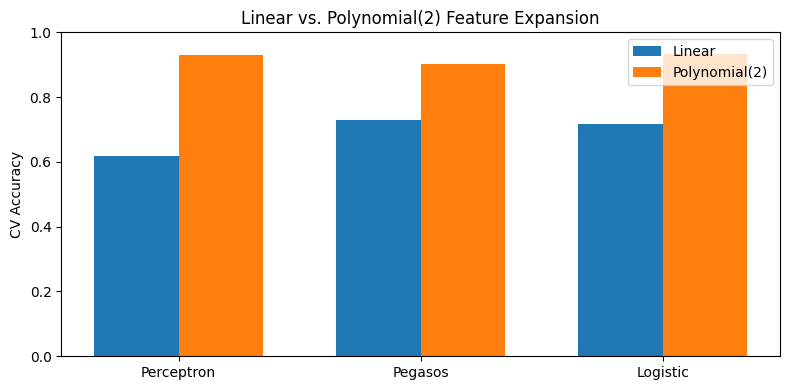

In [32]:
models = ["Perceptron", "Pegasos", "Logistic"]
linear_accs = comparison_poly["Linear"].values
poly_accs   = comparison_poly["Polynomial(2)"].values
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, linear_accs,  width, label='Linear')
plt.bar(x + width/2, poly_accs,    width, label='Polynomial(2)')
plt.xticks(x, models)
plt.ylabel('CV Accuracy')
plt.title('Linear vs. Polynomial(2) Feature Expansion')
plt.ylim([0, 1])
plt.legend()
plt.tight_layout()
plt.show()

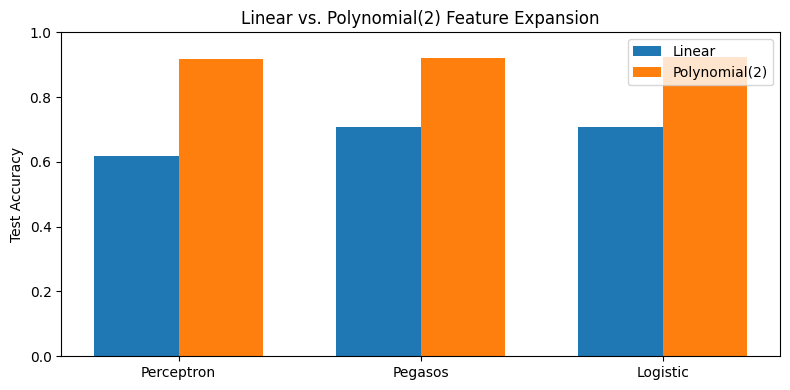

In [33]:
# comparison plot that shows the accuracy of the models on the test set

models = ["Perceptron", "Pegasos", "Logistic"]
linear_accs = [test_acc_perc, test_acc_pega, test_acc_lr]
poly_accs   = [test_acc_poly_perc, test_acc_poly_pega, test_acc_logreg_poly]
x = np.arange(len(models))

plt.figure(figsize=(8,4))
plt.bar(x - width/2, linear_accs,  width, label='Linear')
plt.bar(x + width/2, poly_accs,    width, label='Polynomial(2)')
plt.xticks(x, models)
plt.ylabel('Test Accuracy')
plt.title('Linear vs. Polynomial(2) Feature Expansion')
plt.ylim([0, 1])
plt.legend()
plt.tight_layout()
plt.show()



#### Weights inspection

In [34]:
theta_perc_poly, theta_0_perc_poly = perceptron_train(
    train_poly, 
    features = expanded_feature_cols, 
    target = target_col,
    epochs = 5
)
print(f"Perceptron (poly) final model trained on entire train_poly. Bias (theta_0)= {theta_0_perc_poly:.3f}")

weights_df = pd.DataFrame({
    "Feature": expanded_feature_cols,
    "Weight": theta_perc_poly,
}).sort_values(by="Weight", ascending=False)

# Show top 10 positive weights and top 10 negative weights
print("\nTop 10 Positive Weights:")
display(weights_df.head(10))

print("\nTop 10 Negative Weights:")
display(weights_df.tail(10))

Perceptron (poly) final model trained on entire train_poly. Bias (theta_0)= -18.000

Top 10 Positive Weights:


,Feature,Weight
27,x2*x9,136.522233
5,x8,74.202839
20,x1*x8,41.627963
6,x9,32.383650
3,x5,28.378988
4,x7,24.573826
0,x1,13.552737
7,x10,10.522016
16,x1*x2,9.633112
23,x2*x4,8.616938



Top 10 Negative Weights:


,Feature,Weight
33,x4*x10,-3.441462
35,x5*x8,-4.386635
40,x7*x10,-4.399493
11,x5^2,-6.193885
13,x8^2,-7.196528
8,x1^2,-8.725671
45,x6,-8.816808
17,x1*x4,-12.221037
2,x4,-23.249236
31,x4*x8,-49.045709


In [35]:
theta_pegasos_poly, theta_0_pegasos_poly = pegasos_train(
    train_poly,
    features=expanded_feature_cols,
    target=target_col,
    lambda_param=0.01,
    epochs=5
)
print(f"Pegasos (poly) final model trained on entire train_poly. Bias (theta_0) = {theta_0_pegasos_poly:.3f}")

weights_df = pd.DataFrame({
    "Feature": expanded_feature_cols,
    "Weight": theta_pegasos_poly
}).sort_values(by="Weight", ascending=False)

# Show top 10 positive weights and top 10 negative weights
print("\nTop 10 Positive Weights:")
display(weights_df.head(10))

print("\nTop 10 Negative Weights:")
display(weights_df.tail(10))

Pegasos (poly) final model trained on entire train_poly. Bias (theta_0) = -0.861

Top 10 Positive Weights:


,Feature,Weight
27,x2*x9,2.660367
5,x8,1.529776
20,x1*x8,0.872772
6,x9,0.600717
3,x5,0.581430
4,x7,0.502816
0,x1,0.439973
16,x1*x2,0.158607
35,x5*x8,0.144820
9,x2^2,0.135864



Top 10 Negative Weights:


,Feature,Weight
24,x2*x5,-0.039418
43,x9*x10,-0.040961
38,x7*x8,-0.047762
21,x1*x9,-0.051713
33,x4*x10,-0.065268
8,x1^2,-0.097786
45,x6,-0.100657
17,x1*x4,-0.231290
2,x4,-0.383841
31,x4*x8,-0.745933


#### Weights inspection: the three models compared

In [36]:
#Perceptron Weights
weights_perc_df = pd.DataFrame({
    "Feature": expanded_feature_cols,
    "Weight": theta_perc_poly
}).sort_values(by="Weight", ascending=False)

print("=== Perceptron (Polynomial) Weights ===")
print(f"Bias (theta_0) = {theta0_perc_poly:.3f}")

print("\nTop 10 Positive Weights:")
display(weights_perc_df.head(10))

print("\nTop 10 Negative Weights:")
display(weights_perc_df.tail(10))


#Pegasos Weights
weights_pega_df = pd.DataFrame({
    "Feature": expanded_feature_cols,
    "Weight": theta_pega_poly
}).sort_values(by="Weight", ascending=False)

print("=== Pegasos (Polynomial) Weights ===")
print(f"Bias (theta_0) = {theta0_pega_poly:.3f}")

print("\nTop 10 Positive Weights:")
display(weights_pega_df.head(10))

print("\nTop 10 Negative Weights:")
display(weights_pega_df.tail(10))

#LogReg Weights
weights_logreg_df = pd.DataFrame({
    "Feature": expanded_feature_cols,
    "Weight": theta_logreg_poly
}).sort_values(by="Weight", ascending=False)

print("=== Logistic Regression (Polynomial) Weights ===")
print(f"Bias (theta_0) = {theta0_logreg_poly:.3f}")

print("\nTop 10 Positive Weights:")
display(weights_logreg_df.head(10))

print("\nTop 10 Negative Weights:")
display(weights_logreg_df.tail(10))


=== Perceptron (Polynomial) Weights ===
Bias (theta_0) = -15.000

Top 10 Positive Weights:


,Feature,Weight
27,x2*x9,136.522233
5,x8,74.202839
20,x1*x8,41.627963
6,x9,32.383650
3,x5,28.378988
4,x7,24.573826
0,x1,13.552737
7,x10,10.522016
16,x1*x2,9.633112
23,x2*x4,8.616938



Top 10 Negative Weights:


,Feature,Weight
33,x4*x10,-3.441462
35,x5*x8,-4.386635
40,x7*x10,-4.399493
11,x5^2,-6.193885
13,x8^2,-7.196528
8,x1^2,-8.725671
45,x6,-8.816808
17,x1*x4,-12.221037
2,x4,-23.249236
31,x4*x8,-49.045709


=== Pegasos (Polynomial) Weights ===
Bias (theta_0) = -0.595

Top 10 Positive Weights:


,Feature,Weight
27,x2*x9,2.546420
5,x8,1.446958
20,x1*x8,0.829942
3,x5,0.603095
6,x9,0.576171
0,x1,0.465679
4,x7,0.432479
1,x2,0.139167
16,x1*x2,0.115271
9,x2^2,0.102062



Top 10 Negative Weights:


,Feature,Weight
36,x5*x9,-0.052073
30,x4*x7,-0.057730
12,x7^2,-0.065131
45,x6,-0.075892
10,x4^2,-0.092112
43,x9*x10,-0.096821
8,x1^2,-0.156554
17,x1*x4,-0.198842
2,x4,-0.447579
31,x4*x8,-0.752467


=== Logistic Regression (Polynomial) Weights ===
Bias (theta_0) = -0.796

Top 10 Positive Weights:


,Feature,Weight
27,x2*x9,2.639352
5,x8,1.566495
20,x1*x8,0.843127
3,x5,0.721655
4,x7,0.575441
6,x9,0.572388
0,x1,0.509696
9,x2^2,0.194446
14,x9^2,0.189663
16,x1*x2,0.156268



Top 10 Negative Weights:


,Feature,Weight
37,x5*x10,-0.063438
18,x1*x5,-0.082272
19,x1*x7,-0.099987
7,x10,-0.100965
17,x1*x4,-0.122062
43,x9*x10,-0.123374
8,x1^2,-0.134045
45,x6,-0.158022
2,x4,-0.465224
31,x4*x8,-0.763085


#### Plot

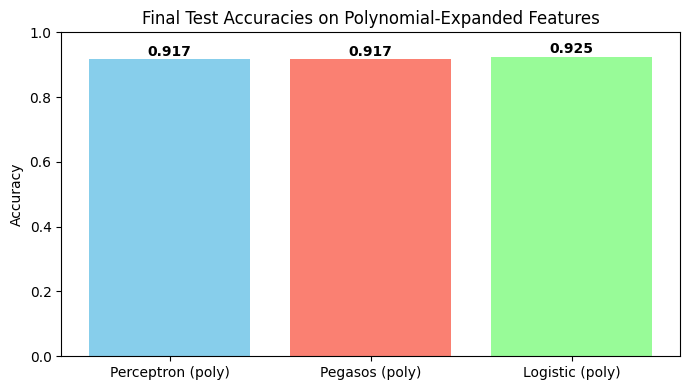

In [37]:
models = ["Perceptron (poly)", "Pegasos (poly)", "Logistic (poly)"]
test_accuracies_poly = [test_acc_poly_perc, test_acc_poly_perc, test_acc_logreg_poly]

plt.figure(figsize=(7,4))
plt.bar(models, test_accuracies_poly, color=["skyblue","salmon","palegreen"])
plt.ylim([0,1])
plt.title("Final Test Accuracies on Polynomial-Expanded Features")
plt.ylabel("Accuracy")
for i, v in enumerate(test_accuracies_poly):
    plt.text(i, v+0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


# Kernel Methods

## Kernelized Perceptron with Gaussian and Polynomial Kernel

In [38]:
k = 5
target_col = "y"

### Gaussian Kernel Perceptron

Traning set evaluation

In [39]:
print("=== Kernelized Perceptron (Gaussian Kernel) ===")
sigma_value = 1.0   # Adjust as needed
epochs_gauss = 5    # Adjust as needed

accuracy_gauss = k_fold_cross_validation(
    df=train_scaled,  # or use a smaller subset if runtime is high
    features=final_features,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: kernelized_perceptron_classifier_func(
        tr_fold, vl_fold, f, t,
        kernel_func=gaussian_kernel,
        kernel_params={"sigma": sigma_value},
        epochs=epochs_gauss
    )
)
print(f"Gaussian Kernel: {k}-fold CV Accuracy = {accuracy_gauss:.3f}")

=== Kernelized Perceptron (Gaussian Kernel) ===
Gaussian Kernel: 5-fold CV Accuracy = 0.939


### Polinomial Kernel Perceptron
Training Set Evaluation

In [40]:
print("\n=== Kernelized Perceptron (Polynomial Kernel) ===")
degree_value = 2    # e.g., quadratic
c_value = 1.0       # offset in (x^T y + c)^degree
epochs_poly = 5

accuracy_poly = k_fold_cross_validation(
    df=train_scaled, 
    features=final_features,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: kernelized_perceptron_classifier_func(
        tr_fold, vl_fold, f, t,
        kernel_func=polynomial_kernel,
        kernel_params={"degree": degree_value, "c": c_value},
        epochs=epochs_poly
    )
)
print(f"Polynomial Kernel (degree={degree_value}): {k}-fold CV Accuracy = {accuracy_poly:.3f}")


=== Kernelized Perceptron (Polynomial Kernel) ===
Polynomial Kernel (degree=2): 5-fold CV Accuracy = 0.925


### Evaluation on Test set
Firstly, the Gaussian Kernel Perceptron

In [41]:
X_train = train_scaled[final_features].values
y_train = train_scaled[target_col].values
X_test = test_scaled[final_features].values
y_test = test_scaled[target_col].values

alpha_gauss = kernelized_perceptron_train(
    X_train, y_train,
    kernel_func=gaussian_kernel,
    kernel_params={"sigma": sigma_value},
    epochs=epochs_gauss
)

test_preds_gauss = kernelized_perceptron_predict(
    X_train, y_train,
    alpha_gauss,
    X_test,
    kernel_func=gaussian_kernel,
    kernel_params={"sigma": sigma_value}
)
test_acc_gauss = np.mean(test_preds_gauss == y_test)
print(f"Gaussian Kernel Perceptron Test Accuracy: {test_acc_gauss:.3f}")


Gaussian Kernel Perceptron Test Accuracy: 0.930


Then the polynomial kernel

In [42]:
alpha_poly = kernelized_perceptron_train(
    X_train, y_train,
    kernel_func=polynomial_kernel,
    kernel_params={"degree": degree_value, "c": c_value},
    epochs=epochs_poly
)

test_preds_poly = kernelized_perceptron_predict(
    X_train, y_train,
    alpha_poly,
    X_test,
    kernel_func=polynomial_kernel,
    kernel_params={"degree": degree_value, "c": c_value}
)
test_acc_poly = np.mean(test_preds_poly == y_test)
print(f"Polynomial (d={degree_value}) Kernel Perceptron Test Accuracy: {test_acc_poly:.3f}")

Polynomial (d=2) Kernel Perceptron Test Accuracy: 0.927


## Kernelized Pegasos SVM

In [43]:
k = 5
target_col = "y"

### Pegasos with Gaussian Kernel

In [44]:
lambda_val = 0.01
epochs_kpega = 5
sigma_val = 1.0

cv_acc_pegasos_gauss = k_fold_cross_validation(
    df=train_scaled,
    features=final_features,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: kernelized_pegasos_classifier_func(
        tr_fold, vl_fold,
        features=f, target=t,
        kernel_func=gaussian_kernel,
        kernel_params={"sigma": sigma_val},
        lambda_param=lambda_val,
        epochs=epochs_kpega
    )
)

print(f"Kernelized Pegasos (Gaussian, sigma={sigma_val}) {k}-fold CV accuracy: {cv_acc_pegasos_gauss:.3f}")


Kernelized Pegasos (Gaussian, sigma=1.0) 5-fold CV accuracy: 0.857


The code above is the actual computation
The code below is ran on a sample for easier computation.

In [45]:
train_sampled = train_scaled.sample(n=400, random_state=42)

lambda_val = 0.01
epochs_kpega = 5
sigma_val = 1.0

cv_acc_pegasos_gauss = k_fold_cross_validation(
    df=train_sampled,
    features=final_features,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: kernelized_pegasos_classifier_func(
        tr_fold, vl_fold,
        features=f, target=t,
        kernel_func=gaussian_kernel,
        kernel_params={"sigma": sigma_val},
        lambda_param=lambda_val,
        epochs=epochs_kpega
    )
)

print(f"Kernelized Pegasos (Gaussian, sigma={sigma_val}) {k}-fold CV accuracy: {cv_acc_pegasos_gauss:.3f}")


Kernelized Pegasos (Gaussian, sigma=1.0) 5-fold CV accuracy: 0.830


Now on the test set

In [46]:


alpha_gauss, T_gauss = kernelized_pegasos_train(
    X_train, y_train,
    kernel_func=gaussian_kernel,
    kernel_params={"sigma": sigma_val},
    lambda_param=lambda_val,
    epochs=epochs_kpega
)
test_preds_gauss = kernelized_pegasos_predict(
    X_train, y_train,
    alpha_gauss, T_gauss,
    X_test,
    kernel_func=gaussian_kernel,
    kernel_params={"sigma": sigma_val},
    lambda_param=lambda_val
)
test_acc_kernel_gauss_pega = (test_preds_gauss == y_test).mean()
print(f"Kernelized Pegasos (Gaussian) Test Accuracy: {test_acc_kernel_gauss_pega:.3f}")


Kernelized Pegasos (Gaussian) Test Accuracy: 0.842


### Pegasos with Polynomial Kernel

In [47]:
degree_val = 2
c_val = 1.0

cv_acc_pegasos_poly = k_fold_cross_validation(
    df=train_scaled,
    features=final_features,
    target=target_col,
    k=k,
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: kernelized_pegasos_classifier_func(
        tr_fold, vl_fold,
        features=f, target=t,
        kernel_func=polynomial_kernel,
        kernel_params={"degree": degree_val, "c": c_val},
        lambda_param=lambda_val,
        epochs=epochs_kpega
    )
)

print(f"Kernelized Pegasos (Polynomial, deg={degree_val}, c={c_val}) {k}-fold CV accuracy: {cv_acc_pegasos_poly:.3f}")


Kernelized Pegasos (Polynomial, deg=2, c=1.0) 5-fold CV accuracy: 0.943


In [48]:
alpha_poly, T_poly = kernelized_pegasos_train(
    X_train, y_train,
    kernel_func=polynomial_kernel,
    kernel_params={"degree": degree_val, "c": c_val},
    lambda_param=lambda_val,
    epochs=epochs_kpega
)
test_preds_poly = kernelized_pegasos_predict(
    X_train, y_train,
    alpha_poly, T_poly,
    X_test,
    kernel_func=polynomial_kernel,
    kernel_params={"degree": degree_val, "c": c_val},
    lambda_param=lambda_val
)
test_acc_kernel_poly_pega = (test_preds_poly == y_test).mean()
print(f"Kernelized Pegasos (Polynomial) Test Accuracy: {test_acc_kernel_poly_pega:.3f}")

Kernelized Pegasos (Polynomial) Test Accuracy: 0.941


# Final Data Visualization

Final Test Accuracy Summary:


,Model,Method,Test Accuracy
0,Logistic,Linear,0.708269
1,Logistic,Polynomial Expansion,0.925013
2,Pegasos,Kernel (Gaussian),0.842322
3,Pegasos,Kernel (Polynomial),0.941448
4,Pegasos,Linear,0.709296
5,Pegasos,Polynomial Expansion,0.920904
6,Perceptron,Kernel (Gaussian),0.930149
7,Perceptron,Kernel (Polynomial),0.926554
8,Perceptron,Linear,0.617360
9,Perceptron,Polynomial Expansion,0.917309


Method,Kernel (Gaussian),Kernel (Polynomial),Linear,Polynomial Expansion
Model,,,,
Logistic,NaN,NaN,0.708269,0.925013
Pegasos,0.842322,0.941448,0.709296,0.920904
Perceptron,0.930149,0.926554,0.617360,0.917309


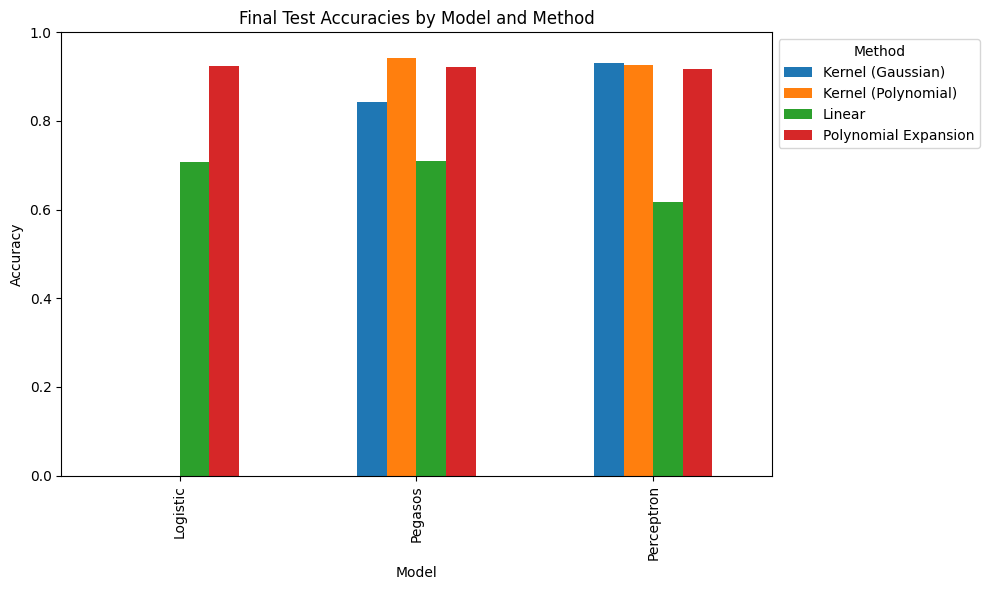

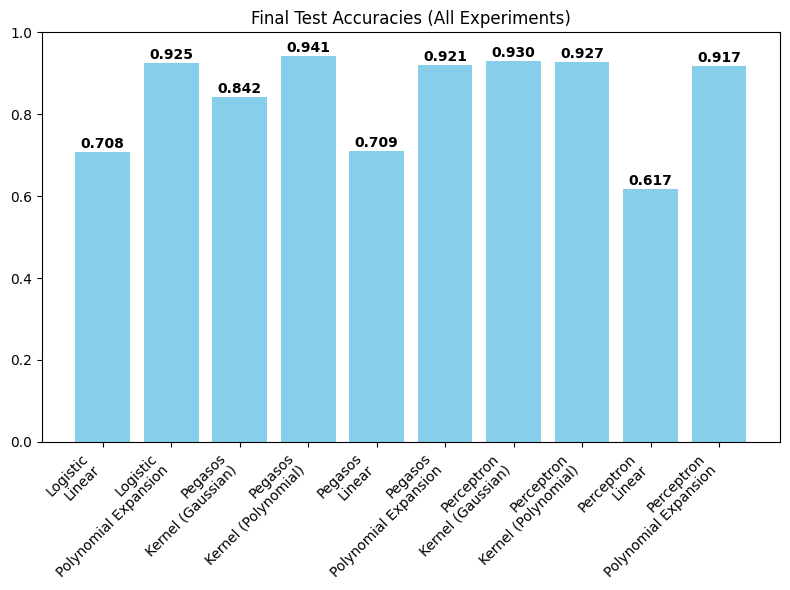

In [49]:
# Example placeholders (DELETE or REPLACE with real computed values):
'''test_acc_perc_linear = 0.80
test_acc_poly_perc = 0.82
test_acc_perc_kernel_gauss = 0.84
test_acc_perc_kernel_poly = 0.83

test_acc_pegasos_linear = 0.81
test_acc_pegasos_poly = 0.83
test_acc_pegasos_kernel_gauss = 0.85
test_acc_pegasos_kernel_poly = 0.84
'''
# If you have logistic regression equivalents, define them too, e.g.:
'''test_acc_logreg_linear = 0.78
test_acc_logreg_poly = 0.80'''

# 1. We'll create a summary DataFrame
final_summary = []

# Perceptron
final_summary.append({
    "Model": "Perceptron",
    "Method": "Linear",
    "Test Accuracy": test_acc_perc
})
final_summary.append({
    "Model": "Perceptron",
    "Method": "Polynomial Expansion",
    "Test Accuracy": test_acc_poly_perc
})
final_summary.append({
    "Model": "Perceptron",
    "Method": "Kernel (Gaussian)",
    "Test Accuracy": test_acc_gauss
})
final_summary.append({
    "Model": "Perceptron",
    "Method": "Kernel (Polynomial)",
    "Test Accuracy": test_acc_poly
})

# Pegasos
final_summary.append({
    "Model": "Pegasos",
    "Method": "Linear",
    "Test Accuracy": test_acc_pega
})
final_summary.append({
    "Model": "Pegasos",
    "Method": "Polynomial Expansion",
    "Test Accuracy": test_acc_poly_pega
})
final_summary.append({
    "Model": "Pegasos",
    "Method": "Kernel (Gaussian)",
    "Test Accuracy": test_acc_kernel_gauss_pega
})
final_summary.append({
    "Model": "Pegasos",
    "Method": "Kernel (Polynomial)",
    "Test Accuracy": test_acc_kernel_poly_pega
})

# (Optional) Logistic
final_summary.append({
    "Model": "Logistic",
    "Method": "Linear",
    "Test Accuracy": test_acc_lr
})
final_summary.append({
    "Model": "Logistic",
    "Method": "Polynomial Expansion",
    "Test Accuracy": test_acc_logreg_poly
})

summary_df = pd.DataFrame(final_summary)
summary_df = summary_df.sort_values(by=["Model", "Method"]).reset_index(drop=True)
print("Final Test Accuracy Summary:")
display(summary_df)


# %%
# Barplot of final test accuracies by Model and Method
# Prepare data
models = summary_df["Model"].unique()
methods = summary_df["Method"].unique()

# Pivot the DataFrame for plotting
pivot_df = summary_df.pivot(index="Model", columns="Method", values="Test Accuracy")
display(pivot_df)

# Plot grouped bar chart
pivot_df.plot(kind="bar", figsize=(10,6))
plt.ylim([0, 1])
plt.title("Final Test Accuracies by Model and Method")
plt.ylabel("Accuracy")
plt.legend(title="Method", bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

# Single bar chart with all methods (Model x Method)
plt.figure(figsize=(8,6))
x_vals = range(len(summary_df))
acc_vals = summary_df["Test Accuracy"].values
labels = [f"{row.Model}\n{row.Method}" for idx, row in summary_df.iterrows()]

plt.bar(x_vals, acc_vals, color="skyblue")
for i, v in enumerate(acc_vals):
    plt.text(i, v+0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.ylim([0,1])
plt.xticks(x_vals, labels, rotation=45, ha="right")
plt.title("Final Test Accuracies (All Experiments)")
plt.tight_layout()
plt.show()
